In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
from src.utils.utils_model import load_model_specific_params
from src.utils.prepare import prepare_model

def load_model(model_name, checkpoint_path):
    model_params = load_model_specific_params(model_name)
    model_params = {
        'num_classes': 10,
        'input_channels': 3,
        'img_height': 32,
        'img_width': 32,
        'overlap': 00,
        **model_params
        }
        
    model = prepare_model(model_name, model_params=model_params)
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    return model


def trace_of_total_covariance(neurons):
    mean_neuron = neurons.mean(axis=0)
    neurons -= mean_neuron
    cov_matrix = (neurons.unsqueeze(2) @ neurons.unsqueeze(1)).mean(axis=0)
    trace = torch.trace(cov_matrix)
    return trace

In [3]:
model_name = 'mm_resnet'
checkpoint_path = '/net/pr2/projects/plgrid/plgg_ccbench/bartek/reports2/all_at_once, training with phase1=0, phase2=180, phase3=0, phase4=0, mm_cifar10, mm_resnet, sgd, overlap=0.0_lr=0.5_wd=0.0_lambda=1.0/2023-12-22_03-19-13/checkpoints/model_step_epoch_180.pth'

model_clean = load_model(model_name, checkpoint_path)
model_clean = model_clean.eval()

In [ ]:
first_conv_layer = model_clean.conv11.weight.data

# Zakładamy, że wagi są w formacie (liczba_filtrów, kanały, wysokość, szerokość)
num_filters = first_conv_layer.shape[0]

# Ustawienie parametrów wykresu
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
normalized_weights = (first_conv_layer - first_conv_layer.min()) / (first_conv_layer.max() - first_conv_layer.min())


for i, ax in enumerate(axes.flat):
    # Wyświetlenie wag w siatce 8x8
    if i < first_conv_layer.shape[0]:  # Sprawdzenie, czy i-ty filtr istnieje
        weight_rgb = np.transpose(normalized_weights[i], (1, 2, 0))
        ax.imshow(weight_rgb)
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()


In [ ]:
first_conv_layer = model_clean.conv21.weight.data

# Zakładamy, że wagi są w formacie (liczba_filtrów, kanały, wysokość, szerokość)
num_filters = first_conv_layer.shape[0]

# Ustawienie parametrów wykresu
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
normalized_weights = (first_conv_layer - first_conv_layer.min()) / (first_conv_layer.max() - first_conv_layer.min())


for i, ax in enumerate(axes.flat):
    # Wyświetlenie wag w siatce 8x8
    if i < first_conv_layer.shape[0]:  # Sprawdzenie, czy i-ty filtr istnieje
        weight_rgb = np.transpose(normalized_weights[i], (1, 2, 0))
        ax.imshow(weight_rgb)
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()


# CAPTUM

In [ ]:
!git clone https://github.com/pytorch/captum
%cd captum
!git checkout "optim-wip"
!pip3 install -e .
import sys
sys.path.append('/content/captum')
%cd ..

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [4]:
import captum
import captum.optim as optimviz
import torch
import torchvision
from captum.optim.models import googlenet

device = torch.device("cpu")

In [46]:
from typing import Callable, Dict, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

LossFunction = Callable[[Dict[torch.nn.Module, Optional[torch.Tensor]]], torch.Tensor]


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def vis_neuron_large(
    model: torch.nn.Module, target: torch.nn.Module, channel: int, figsize: Tuple[int, int], steps: int
) -> None:
    image = optimviz.images.NaturalImage(figsize).to(device)
    transforms = torch.nn.Sequential(
        optimviz.transforms.CenterCrop(figsize),
    )
    loss_fn = optimviz.loss.NeuronActivation(target, channel)
    obj = optimviz.InputOptimization(model=model, loss_function=loss_fn, input_param=image, transform=transforms)
    history = obj.optimize(optimviz.optimization.n_steps(steps, False))
    return image().detach().numpy()


def vis_neuron(
    model: torch.nn.Module, target: torch.nn.Module, loss_fn: LossFunction, figsize: Tuple[int, int], steps: int
) -> torch.Tensor:
    image = optimviz.images.NaturalImage(figsize).to(device)
    transforms = torch.nn.Sequential(
        # torch.nn.ReflectionPad2d(4),
        # optimviz.transform.RandomSpatialJitter(8),
        # optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        # torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        # optimviz.transform.RandomSpatialJitter(2),
        optimviz.transform.CenterCrop(figsize),
    )
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.optimization.n_steps(steps, False))
    return image()._t


def visualize_neuron_list(
    model: torch.nn.Module, target: torch.nn.Module, neuron_list: List[int], figsize: Tuple[int, int], steps: int
) -> List[torch.Tensor]:
    A = []
    for n in neuron_list:
        loss_fn = optimviz.loss.NeuronActivation(target, n, figsize, steps)
        x_out = vis_neuron(model, target, loss_fn)
        A.append(x_out.detach())
    return A


class Model(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        
    def forward(self, x):
        x = self.model(x)
        return x
    
def save_imgs(img1, img2, save_path):
    """
    Funkcja do łączenia dwóch zdjęć w formacie RGB reprezentowanych jako array numpy
    i zapisywania ich jako jednego zdjęcia w wskazanym miejscu.

    Parametry:
    zdjecie1 (numpy array): Pierwsze zdjęcie w formacie RGB.
    zdjecie2 (numpy array): Drugie zdjęcie w formacie RGB.
    sciezka_zapisu (str): Ścieżka do zapisu połączonego zdjęcia.
    """
    # Sprawdzenie czy oba zdjęcia mają taki sam rozmiar
    if img1.shape != img2.shape:
        raise ValueError("Zdjęcia muszą mieć ten sam rozmiar")

    # Połączenie obu zdjęć w jedno, umieszczając je obok siebie
    polaczone_zdjecie = np.concatenate((img1, img2), axis=1)

    # Zapisanie połączonych zdjęć do pliku
    plt.imsave(save_path, polaczone_zdjecie)

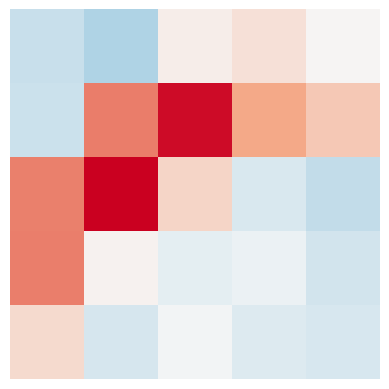

In [4]:
model = googlenet(pretrained=True).to(device).eval()


# Load InceptionV1 model with nonlinear layers replaced by their linear equivalents
linear_model = googlenet(pretrained=True, use_linear_modules_only=True).to(device).eval()

W_3a_3b = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.mixed3a, linear_model.mixed3b, 5)

W_3a_3b_hm = optimviz.weights_to_heatmap_2d(W_3a_3b[379, 147, ...] / W_3a_3b[379, ...].max())
show(W_3a_3b_hm)

In [66]:
figsize = (128, 128)
steps = 128

layer = model_clean.conv11

left_branch = Model(model_clean.left_branch)

img1 = vis_neuron_large(left_branch, layer, 0, figsize, steps)
img2 = vis_neuron_large(left_branch, layer, 1, figsize, steps)
# vis_neuron_large(model, model.mixed3b, 379, figsize, steps)

In [67]:
img1 = img1.squeeze().transpose(1,2,0)
img2 = img2.squeeze().transpose(1,2,0)

In [68]:
img1.shape

(128, 128, 3)

In [69]:
save_path = 'feature/mm_resnet/0/0_test.png'

In [70]:
save_imgs(img1, img2, save_path)

In [86]:
for module in model_clean.right_branch.modules():
    if isinstance(module, torch.nn.Conv2d):
        print(module)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [ ]:
class Model(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        
    def forward(self, x):
        x = self.model(x)
        return x
    
model_clean.left_branch = Model(model_clean.left_branch)
model_clean.right_branch = Model(model_clean.right_branch)

In [ ]:
for idx in range(model_clean.conv11.weight.shape[0]):
    print('channel: ', idx)
    vis_neuron_large(model_clean.left_branch, model_clean.conv11, idx)
    vis_neuron_large(model_clean.right_branch, model_clean.conv21, idx)